# Convert existing AnnData into RamData for collaborative data sharing and Web Application
v2023-11-24

In this tutorial, an existing AnnData object will be converted to RamData object.


The resulting RamData object, when uploaded to a cloud (e.g., Amazon S3) or a public GitHub repository, can be analyzed remotely using SC-Elephant, simplifying a collaborative data analysis process of large single-cell datasets.


Using the RamData object, we will search for a rare cell type (Aerocyte, or aCap) and fetch the complete gene expression counts of possible aerocytes in a memory-efficient manner.


To view all the HTML components of this Jupyter Notebook, please view **[Tutorial 4) Convert existing AnnData into RamData for collaborative data sharing](https://scelephant-free.s3.amazonaws.com/doc/SC-Elephant_Convert_AnnData_to_RamData_for_collaborative_data_sharing.html)**

In [1]:
""" 
Reset the tutorial
"""
# delete the intermediate output folders to reset the tutorials
!rm -rf "convert_h5ad_to_RamData/"

In [2]:
"""
Download a large H5AD to use as an example, using a publicly available COVID-19 Cell Atlas dataset
"""
!mkdir -p convert_h5ad_to_RamData/data/

!wget https://covid19.cog.sanger.ac.uk/madissoon19_lung.processed.h5ad -O convert_h5ad_to_RamData/data/madissoon19_lung.processed.h5ad

!mkdir -p convert_h5ad_to_RamData/output

--2023-11-24 20:54:20--  https://covid19.cog.sanger.ac.uk/madissoon19_lung.processed.h5ad
Resolving covid19.cog.sanger.ac.uk (covid19.cog.sanger.ac.uk)... 193.62.203.63, 193.62.203.62, 193.62.203.61
Connecting to covid19.cog.sanger.ac.uk (covid19.cog.sanger.ac.uk)|193.62.203.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209637686 (200M) [application/x-hdf]
Saving to: ‘convert_h5ad_to_RamData/data/madissoon19_lung.processed.h5ad’

convert_h5ad_to_Ram 100%[===================>] 199.93M  3.59MB/s    in 7m 2s   

2023-11-24 21:01:23 (485 KB/s) - ‘convert_h5ad_to_RamData/data/madissoon19_lung.processed.h5ad’ saved [209637686/209637686]



In [3]:
"""
Import necessary packages
"""
# not use GPU (only inference will be performed, and using CPUs are sufficient)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc
# set figure parameters
sc.set_figure_params( dpi = 200, figsize = ( 6, 5 ), frameon = True )

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

## **Convert an AnnData object (in-memory object) to RamData object (on-disk object)**

In [4]:
'''
Load a AnnData object into the memory
'''
# read an AnnData object
adata = sc.read_h5ad( 'convert_h5ad_to_RamData/data/madissoon19_lung.processed.h5ad' ) # contains log-normalized count data

In [5]:
# initialize a pool of managed operators # once is enough for each tutorial
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

In [6]:
# check whether the AnnData contains the raw count data
arr = adata.X[ :, 0 ].toarray( ).ravel( )
arr[ arr > 0 ] 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [7]:
'''
Convert AnnData to a RamData object
'''
name_layer = 'raw' # for the current example AnnData downloaded from COVID-19 Cell Atlas, AnnData.X contains Raw count data
el.create_ramdata_from_adata(
    adata, # an AnnData object
    path_folder_ramdata_output = "convert_h5ad_to_RamData/output/madissoon19_lung.processed.ramdata/", # output directory
    set_modes = {
        'sparse_for_querying_features', # for querying gene expression counts of individual genes
        'sparse_for_querying_barcodes', # for querying gene expression counts of individual cells
    },
    name_layer = name_layer, # name of the exported RamDataLayer, which will contain data in the AnnData.X 
    file_system_operator_pool = fop,
)

RAMtx (sparse_for_querying_barcodes): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84196917/84196917 [00:26<00:00, 3135275.95it/s]
2023-11-24 21:02:05,446 [SC-Elephant] <INFO> (create_ramtx_from_adata) - Exporting of a RAMtx object at 'convert_h5ad_to_RamData/output/madissoon19_lung.processed.ramdata/raw/sparse_for_querying_barcodes/' was completed
2023-11-24 21:02:05,985 [SC-Elephant] <INFO> (create_ramdata_from_adata) - Exporting of a RamData object at 'convert_h5ad_to_RamData/output/madissoon19_lung.processed.ramdata/' was completed


## **Loading a RamData**

In [8]:
ram = RamData( 
    "convert_h5ad_to_RamData/output/madissoon19_lung.processed.ramdata/",
    int_total_weight_for_each_batch = 350_000, # increase the batch size for better performance
    int_num_cpus = 8,
    file_system_operator_pool = fop,
    flag_enable_synchronization_through_locking = False, # You can set it to False for better performance, but when this RamData object is being modified by other researchers, setting to True is highly recommended to avoid collisions
)

2023-11-24 21:02:06,071 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


In [9]:
ram.ft.load_str( ) # load all gene names into the memory

2023-11-24 21:02:06,159 [SC-Elephant] <INFO> (load_str) - completed loading of 25204 number of strings


array(['RP11-34P13.7', 'RP11-34P13.8', 'FO538757.3', ..., 'AC233755.2',
       'AC233755.1', 'AC240274.1'], dtype=object)

## **View RamData**
- JavaScript-based interactive visualization of RamData object in Jupyter Notebook

In [10]:
ram

<RamData object (57020 barcodes X 25204 features, 84196917 records in the currently active layer 'raw') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/convert_h5ad_to_RamData/output/madissoon19_lung.processed.ramdata/
	with the following layers : {'raw'}
		current layer is 'raw'>

## **From a RamData object, fetch cell metadata and expression counts of the genes of interest as an AnnData object**

In [11]:
l_name_genes = [ 
    'PTPRC', 
    'EPCAM', 
    'PECAM1', # Endothelial cell marker 
    'EDNRB', # Lung aCap marker gene
    'CA4' # Lung aCap marker gene
] # list of name of genes
adata = ram[
    name_layer, # name of the layer
    :, # load all barcodes
    [ 'str', 'CellType', 'Doner', 'patient', { 'X_umap' } ], # [Barcode Metadata] the names of the columns containing 2D matrices should be given as a set # 'str' for loading the string representations. if 'str' is not included, each barcode will be represened by integer indices of the barcode axis
    l_name_genes, # gene name list 
    [ 'str' ], # load gene names
]

2023-11-24 21:02:06,388 [SC-Elephant] <INFO> (load_str) - completed loading of 57020 number of strings


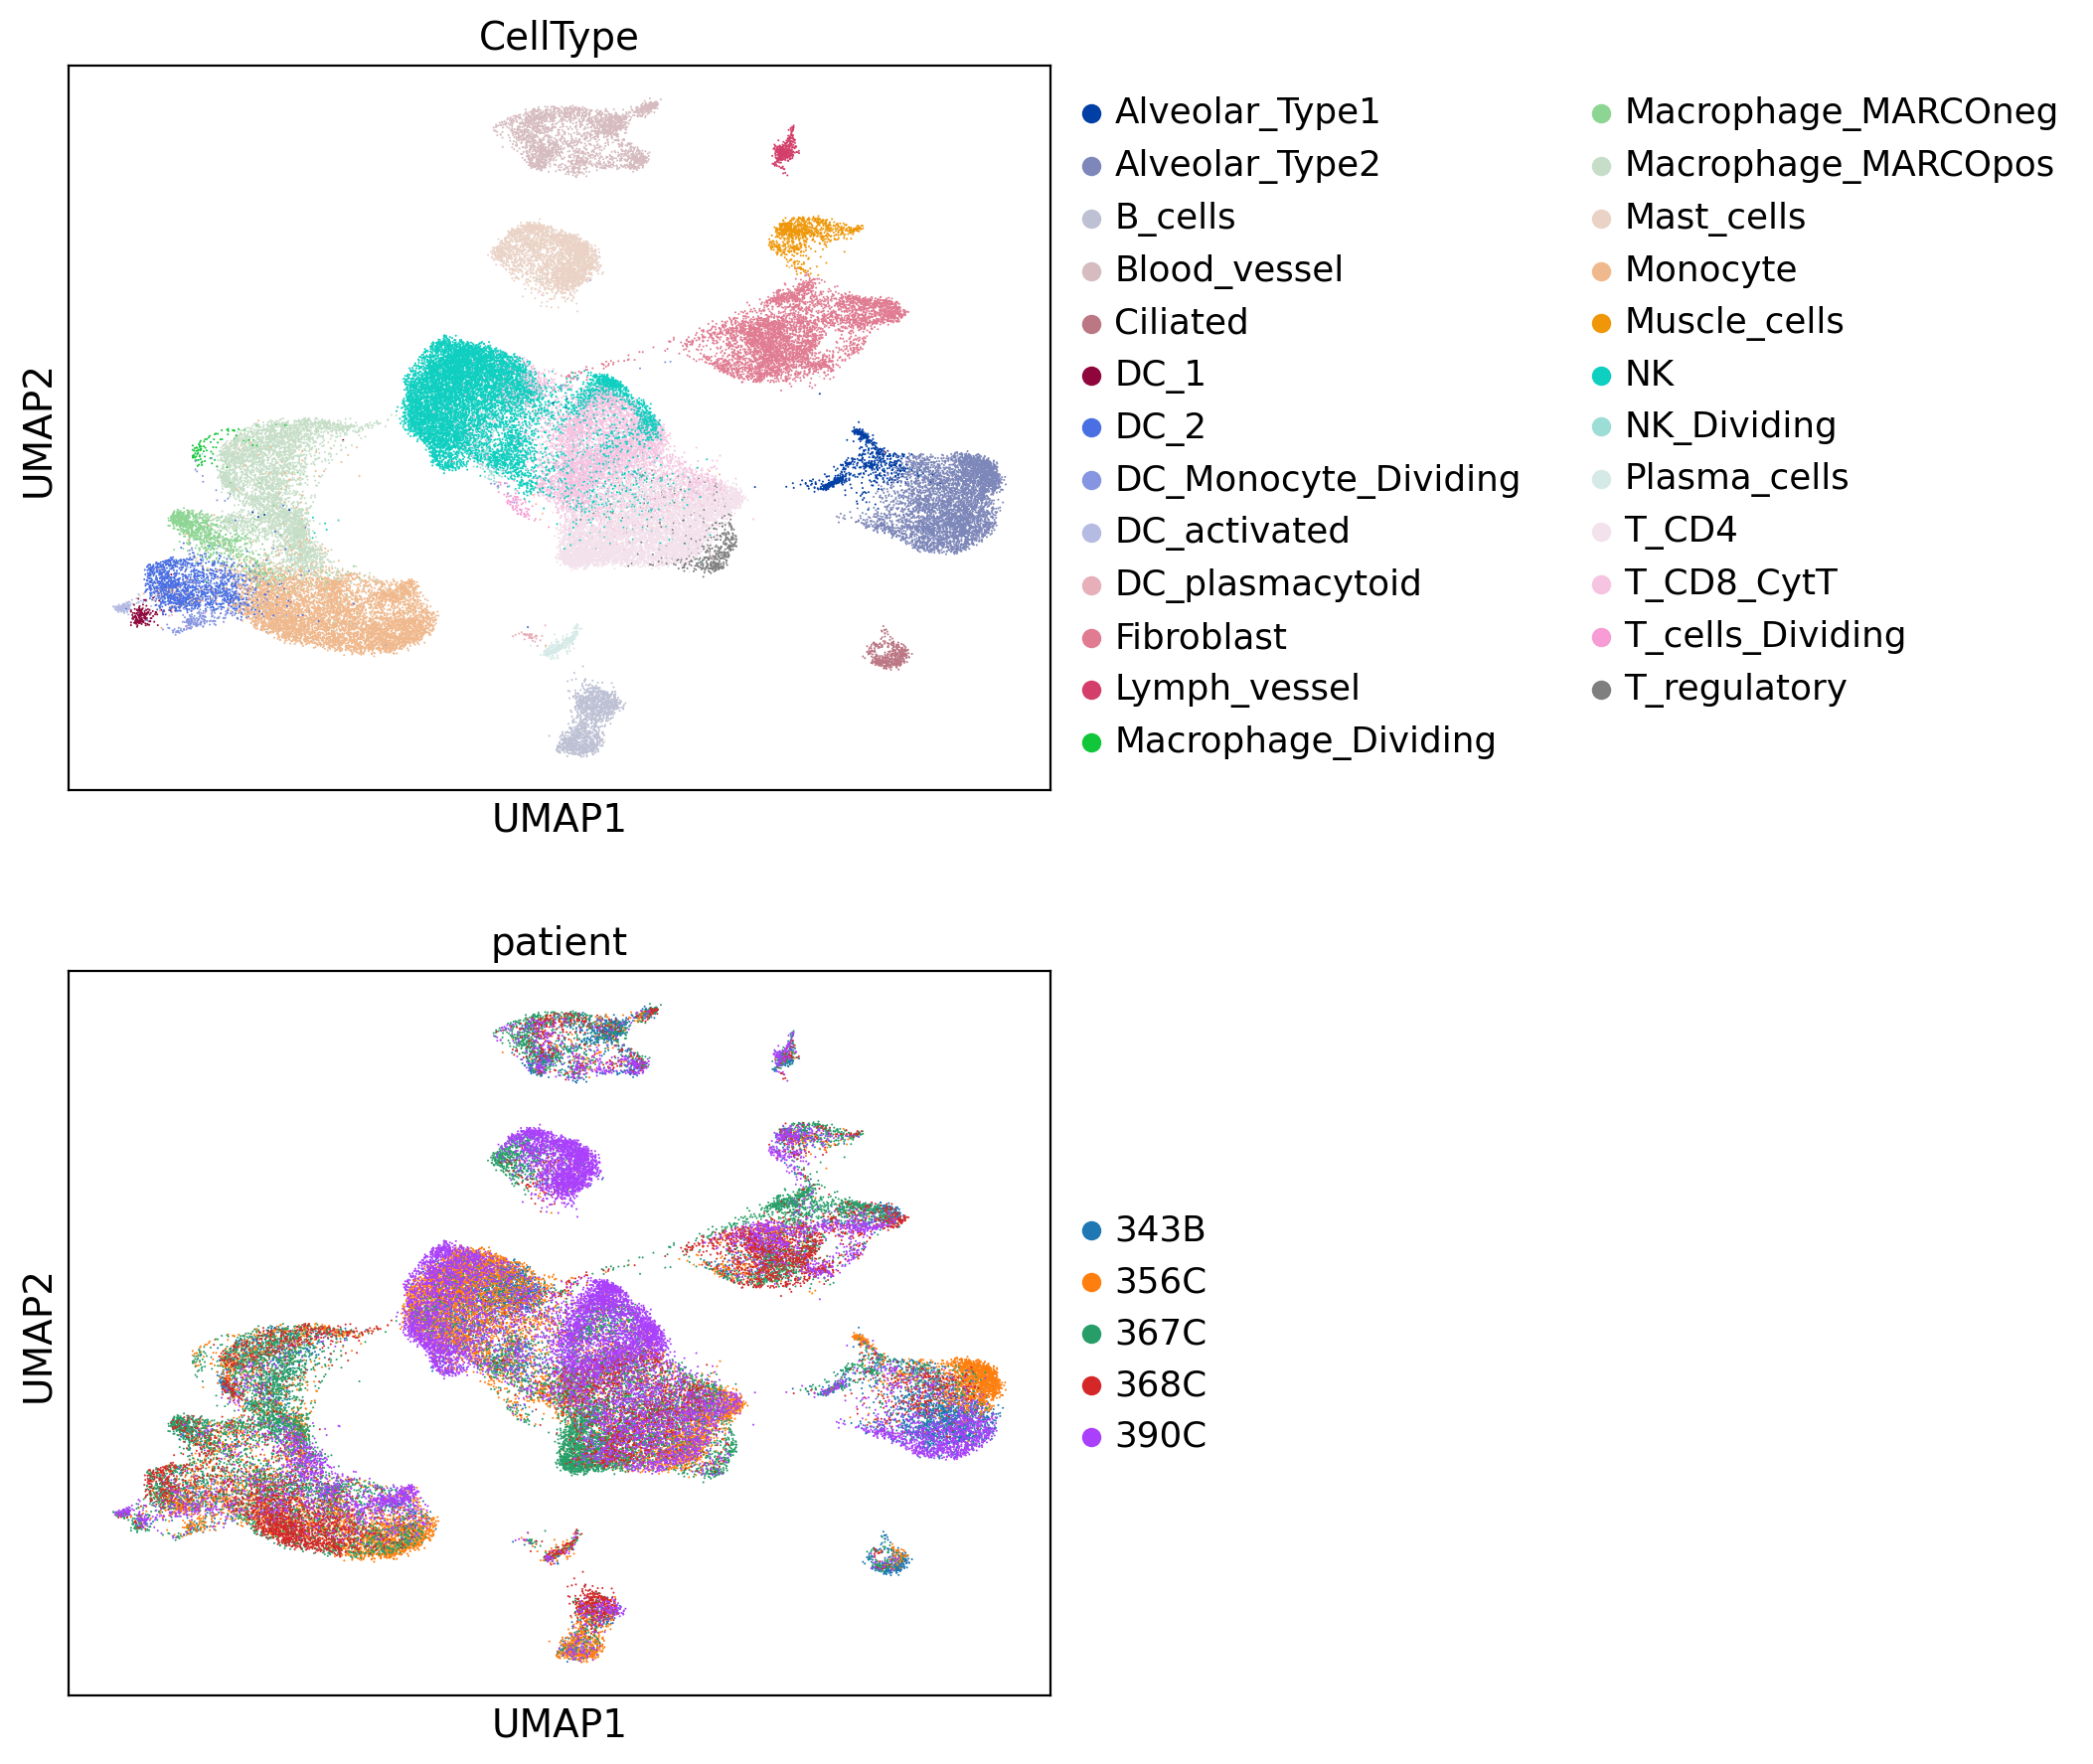

In [12]:
sc.pl.umap( adata, color = [ 'CellType', 'patient', ], ncols = 1 )

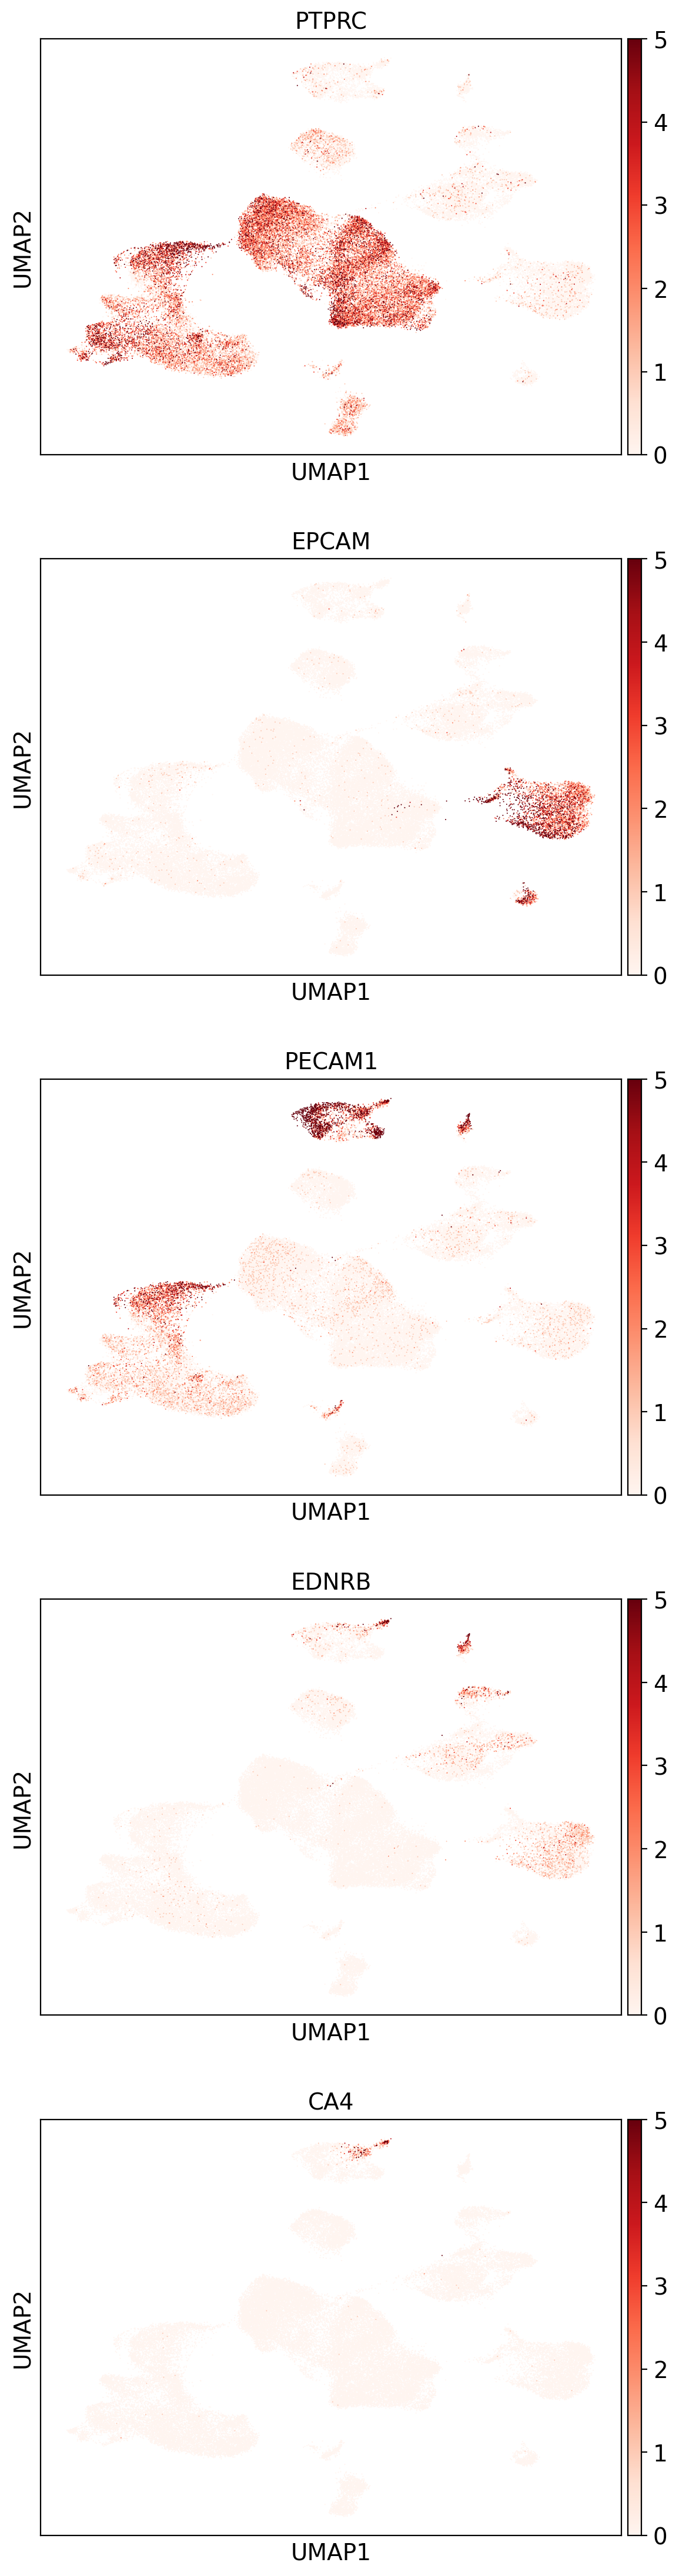

In [13]:
sc.pl.umap( adata, color = l_name_genes, cmap = 'Reds', vmax = 5, ncols = 1 )

## **Create a selection filter to mark possible aerocytes (aCap) in the dataset in a memory efficient manner**

In [14]:
# retrieve expressions values of genes of interest
ram.get_expr( 
    queries = [
        'EDNRB', 
        'CA4',
    ],
    name_layer = name_layer
)

2023-11-24 21:02:10,479 [SC-Elephant] <INFO> (load_str) - completed loading of 25204 number of strings


array([2., 0., 0., ..., 0., 0., 0.])

In [15]:
'''
Create a filter marking the possible aerocytes based on the expression counts of their marker genes
'''
ram.bc.save_as_filter( 
    ( ram.get_expr( [ 'EDNRB', 'CA4', ] ) > 0 ) & ( ram.get_expr( [ 'PECAM1', ] ) > 0 ),
    name_col_filter = 'filter_aCap', 
    dict_col_metadata_description = {
        'intended_function' : 'filter',
        'description' : "filter containing alveolar capillary cell, aerocytes (aCap), selected using EDNRB, CA4, and PECAM1 expressions",
    }
)

# change the barcode filter to select (possible) aerocytes
ram.bc.change_filter( 'filter_aCap' )

2023-11-24 21:02:10,559 [SC-Elephant] <INFO> (load_str) - completed loading of 25204 number of strings
2023-11-24 21:02:10,625 [SC-Elephant] <INFO> (load_str) - completed loading of 25204 number of strings


## **View a RamData object with active filters**
- JavaScript-based interactive visualization of RamData object in Jupyter Notebook

In [16]:
ram

<RamData object (826/57020 barcodes X 25204 features, 84196917 records in the currently active layer 'raw') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/convert_h5ad_to_RamData/output/madissoon19_lung.processed.ramdata/
	with the following layers : {'raw'}
		current layer is 'raw'>

## **Fetch full gene expression counts of possible aerocytes as an AnnData and perform the downstream analysis**

In [17]:
ram.int_num_cpus_for_fetching_data = 3 # using multiprocessing to fetch data more efficiently
adata_subset = ram[
    name_layer,
    :, # retrieve all barcodes in the CURRENTLY ACTIVE FILTER
    [ 'str',  'CellType', 'Doner', 'patient', { 'X_umap', 'X_pca' } ], # retrieve barcode-associated data
    :, # retrieve all features in the axis (since no filter is active, all genes will be retrieved)
    [ 'str' ]
] # retrieve a full count matrix of possible aerocytes, a subset of specialized lung capillary cells

2023-11-24 21:02:10,840 [SC-Elephant] <INFO> (load_str) - completed loading of 826 number of strings
2023-11-24 21:02:10,931 [SC-Elephant] <INFO> (load_str) - completed loading of 25204 number of strings


In [18]:
adata_subset

AnnData object with n_obs × n_vars = 826 × 25201
    obs: 'CellType', 'patient'
    obsm: 'X_pca', 'X_umap'

In [19]:
adata_subset.obsm[ 'X_pca' ].shape

(826, 50)

2023-11-24 21:02:17.853921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 21:02:18.058688: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 21:02:18.094399: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-24 21:02:18.848543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

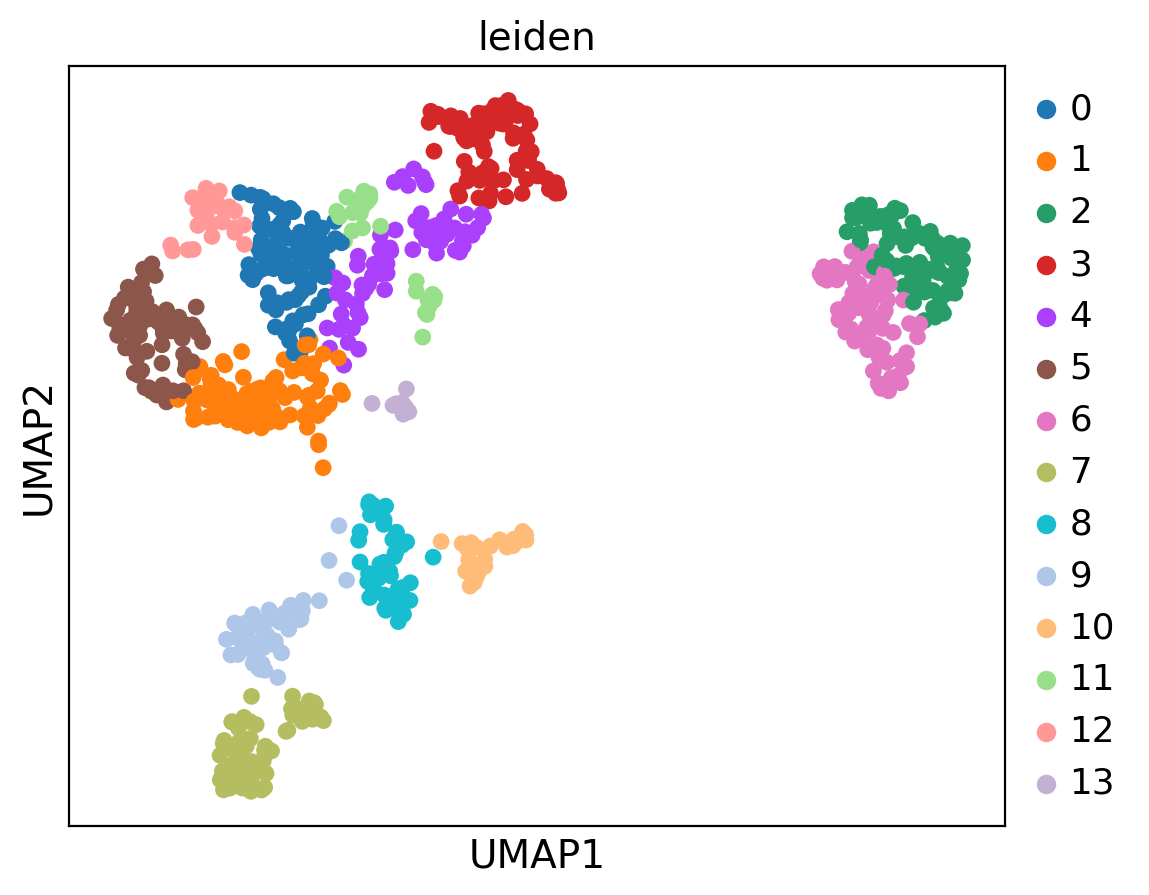

In [20]:
sc.pp.neighbors(adata_subset, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_subset)
sc.tl.leiden(adata_subset, resolution = 1 )
sc.pl.umap( adata_subset, color = ['leiden' ] )
sc.tl.rank_genes_groups(adata_subset, 'leiden', method='wilcoxon') # search marker genes 

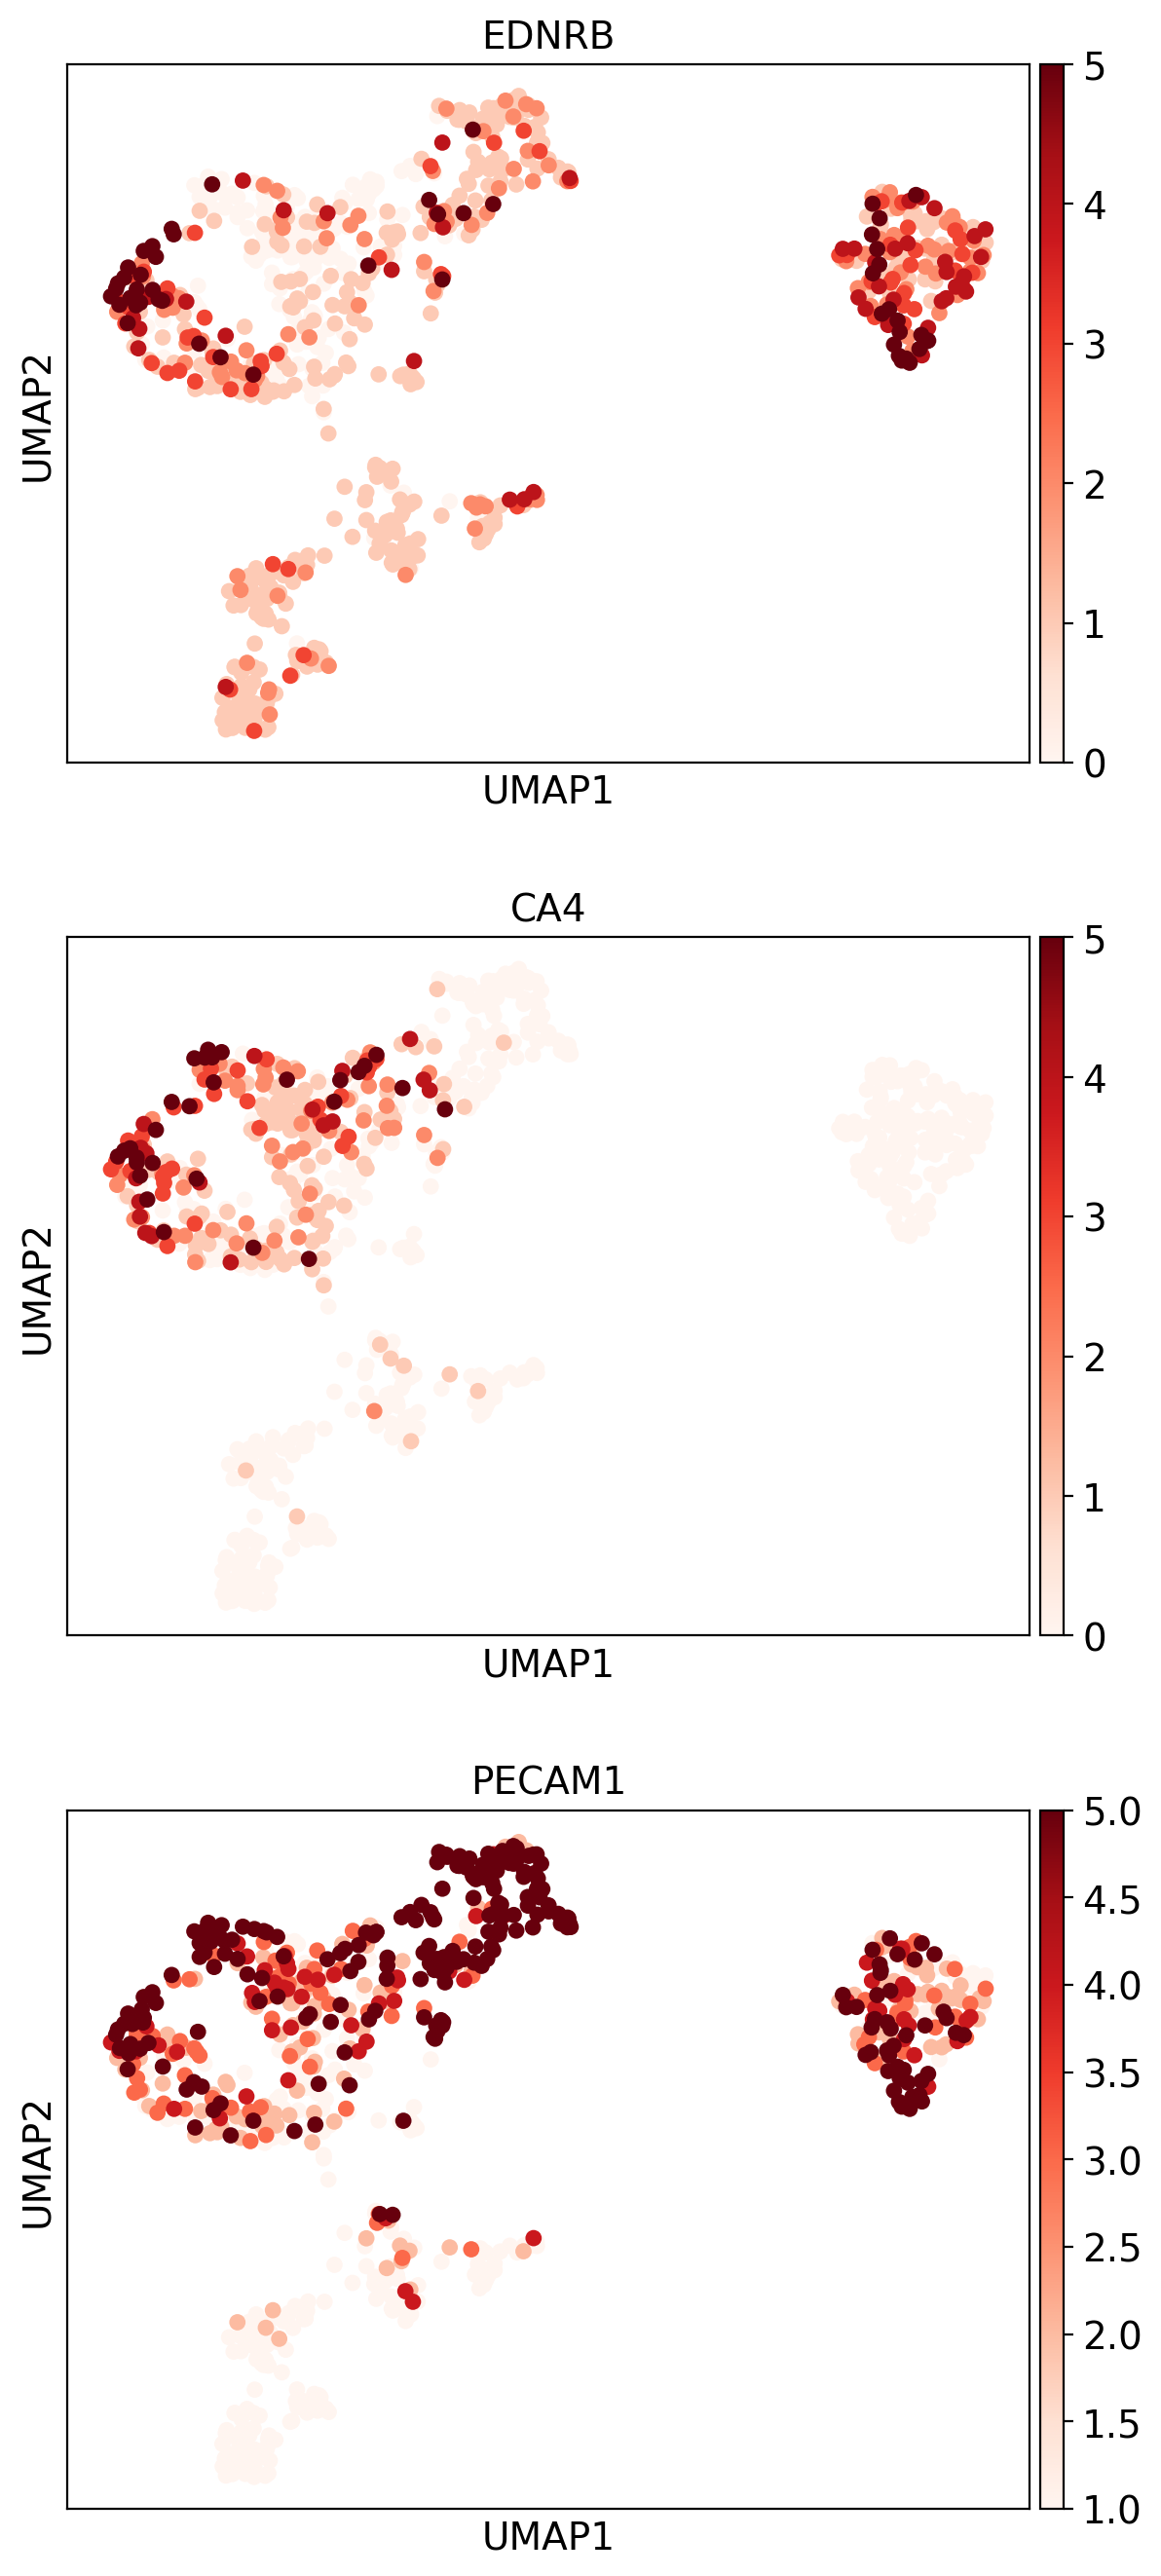

In [21]:
sc.pl.umap( adata_subset, color = [ 'EDNRB', 'CA4', 'PECAM1' ], cmap = 'Reds', vmax = 5, ncols = 1 )

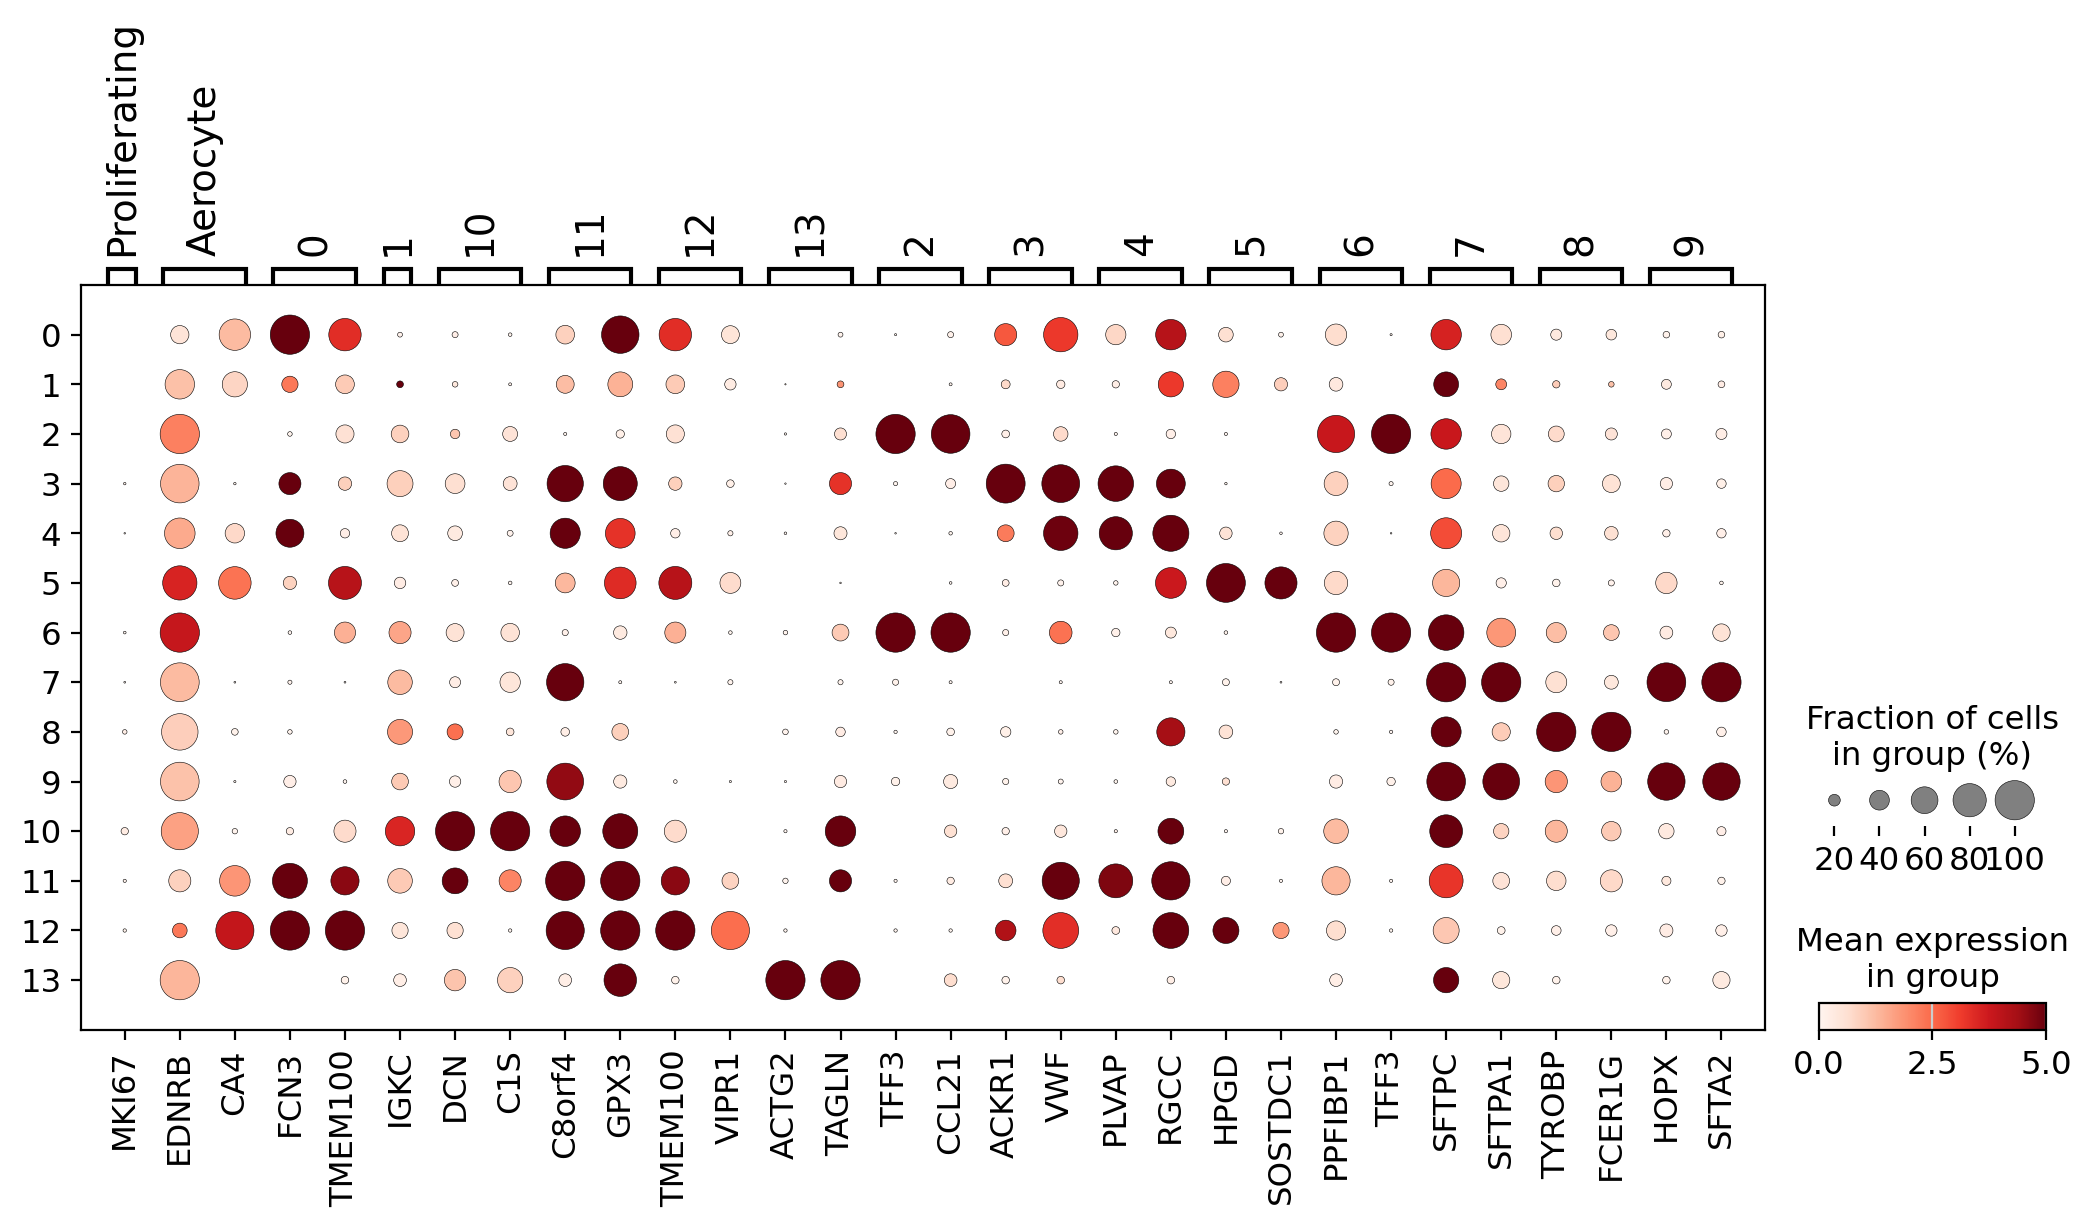

In [22]:
''' retrieve markers for the subset of AnnData '''
# settings
int_num_markers_for_cell_type = 2

_df = el.SCANPY_Retrieve_Markers_as_DataFrame( adata_subset )
_df = _df[ ( _df[ 'pvals_adj' ].values < 1e-2 ) & ( _df[ 'logfoldchanges' ].values > 1 ) ]
dict_genes = {
    'Proliferating' : [ 'MKI67' ],
    'Aerocyte' : [ 'EDNRB', 'CA4', ],
}
for name_clus, __df in _df.groupby( 'name_clus' ) :
    dict_genes[ name_clus ] = __df.sort_values( 'scores', ascending = False ).iloc[ : int_num_markers_for_cell_type ].names.values
    
# draw dotplot
sc.pl.dotplot( adata_subset, dict_genes, groupby = 'leiden', vmax = 5 )